# CS 4641 HW1 Code - Learning

This file will provide analysis for 5 different classification algorithms for two datasets.

Dataset: Phishing Websites.

Classification Algorithms: Decision Tree, Boosting, KNN, SVM, Neural Network.

There will be two outputs for each model: a plot of learning curve and a plot of model complexity. Both plots will be generated after hyperparameter tuning is performed.

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [1]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

os.chdir(r"/home/tuanyuan2008/") #change this to your current working directory

### Load the Phishing Website Data

In [2]:
## Download the Phishing Data from OpenML https://www.openml.org/d/4534

df_phish = pd.read_csv('PhishingWebsitesData.csv').astype('category')
print("Data has",len(df_phish),"rows and", len(df_phish.columns),"columns.")
if df_phish.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')

('Data has', 11055, 'rows and', 31, 'columns.')


Now that the phishing data is loaded, we need to do some preprocessing. Several of the columns are categorical with the levels {-1,0,1} and the rest are all binary with levels {-1,1}. For the 3-level columns we will use one-hot encoding to create additional features with level {0,1}. Finally, we will edit the binary features so that the new levels are all {0,1}. We will have more features now, but they will all be binary.

In [3]:
col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
df_1hot = df_phish[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_phish.drop(col_1hot,axis=1)
df_phish = pd.concat([df_1hot,df_others],axis=1)
df_phish = df_phish.replace(-1,0).astype('category')
column_order = list(df_phish)
column_order.insert(0, column_order.pop(column_order.index('Result')))
df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front
df_phish.describe(include='all')

,Result,URL_Length_-1,URL_Length_0,URL_Length_1,having_Sub_Domain_-1,having_Sub_Domain_0,having_Sub_Domain_1,SSLfinal_State_-1,SSLfinal_State_0,SSLfinal_State_1,...,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,Page_Rank,Google_Index,Statistical_report
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,...,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,1,1,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,1,0,1,1
freq,6157,8960,10920,9095,7692,7433,6985,7498,9888,6331,...,9776,9740,10579,8918,10043,5866,7612,8201,9516,9505


We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The phishing data is ready to go!

Now we have successfully loaded and processed our dataset. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_phish.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_phish.values[:,0],dtype='int64')

    return X1, Y1

def learning_curve(clf,X_train, X_test, y_train, y_test):
    offsets = range(int(0.1 * len(X_train)), len(X_train), int(0.03 * len(X_train)))

    train_error = [0] * len(offsets)
    test_error = [0] * len(offsets)
    
    for i, o in enumerate(offsets):
        clf.fit(X_train[:o], y_train[:o])

        y_pred = clf.predict(X_test[:o])
        train_pred = clf.predict(X_train[:o])

        error = 1 - accuracy_score(y_test[:o],y_pred)
        trainErr = 1 - accuracy_score(y_train[:o], train_pred)

        test_error[i] = (error)
        train_error[i] = (trainErr)
        
        print("Offsets\t\tTrain Err\t\tTest Err")
        print("%.6d\t\t%.6f\t\t%.6f" % (o, train_error[i], test_error[i]))

    plt.figure()
    plt.plot(offsets, test_error, '-', label='test error')
    plt.plot(offsets, train_error, '-', label='train error')
    plt.title('Performance x Training Set Size')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend(loc='lower right')
    plt.show()
    

def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

# 3. The Fun Part: Machine Learning!

# Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate.

In [5]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

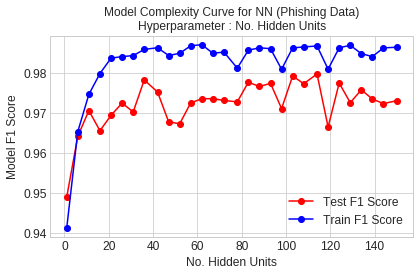

/usr/lib64/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Per Hyperparameter tuning, best parameters are:
{'learning_rate_init': 0.01, 'hidden_layer_sizes': 100}


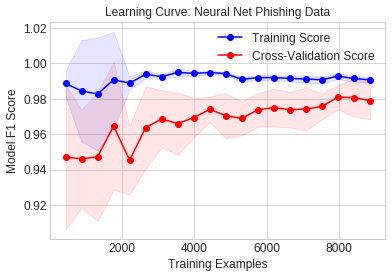

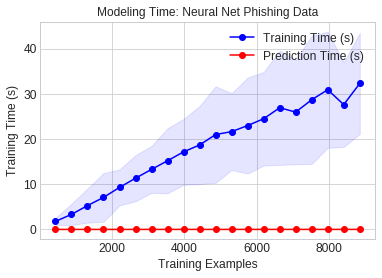

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   8.64022
Model Prediction Time (s): 0.00548

F1 Score:  0.98
Accuracy:  0.97     AUC:       0.97
Precision: 0.97     Recall:    0.98
*****************************************************


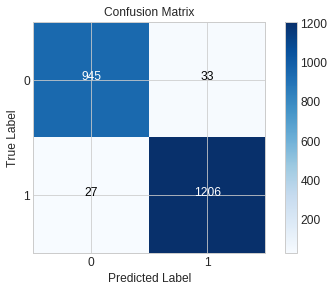

In [6]:
phishX,phishY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
hyperNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Phishing Data)\nHyperparameter : No. Hidden Units")
h_units, learn_rate = NNGridSearchCV(X_train, y_train)
estimator_phish = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='logistic', 
                               learning_rate_init=learn_rate, random_state=100)
train_samp_phish, NN_train_score_phish, NN_fit_time_phish, NN_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Neural Net Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

This section will create a surface plot for the Phishing data to see where the local and global maxima occur for different numbers of hidden units for a network with 2 hidden layers.

# Support Vector Machine Classifier

This section will build a support vector machine classifier. The primary hyperparameter will be kernel function: linear, polynomial, rbf (radial basis function), and sigmoid. We will also explore the penalty term 'C' and the kernel coefficient 'gamma'.

In [7]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    Cs = [1e-4, 1e-3, 1e-2, 1e01, 1]
    gammas = [1,10,100]
    param_grid = {'C': Cs, 'gamma': gammas}

    clf = GridSearchCV(estimator = SVC(kernel='rbf',random_state=100),
                       param_grid=param_grid, cv=10)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['gamma']

/usr/lib64/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


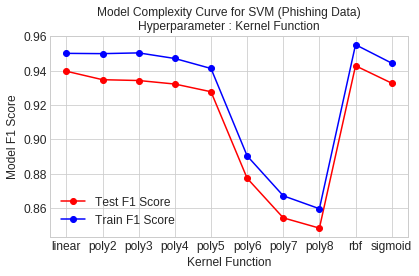

Per Hyperparameter tuning, best parameters are:
{'C': 10.0, 'gamma': 1}
Offsets		Train Err		Test Err
000884		0.004525		0.160633
Offsets		Train Err		Test Err
001149		0.004352		0.136641
Offsets		Train Err		Test Err
001414		0.004243		0.137199
Offsets		Train Err		Test Err
001679		0.004765		0.113758
Offsets		Train Err		Test Err
001944		0.004115		0.105453
Offsets		Train Err		Test Err
002209		0.004980		0.100951
Offsets		Train Err		Test Err
002474		0.005255		0.105382
Offsets		Train Err		Test Err
002739		0.006207		0.099502
Offsets		Train Err		Test Err
003004		0.006325		0.095432
Offsets		Train Err		Test Err
003269		0.007954		0.087291
Offsets		Train Err		Test Err
003534		0.007923		0.086386
Offsets		Train Err		Test Err
003799		0.008686		0.080054
Offsets		Train Err		Test Err
004064		0.008612		0.078697
Offsets		Train Err		Test Err
004329		0.008316		0.074175
Offsets		Train Err		Test Err
004594		0.008489		0.071461
Offsets		Train Err		Test Err
004859		0.008644		0.064677
Offsets		Train Err		Test Err
005

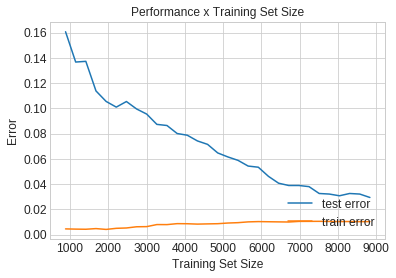

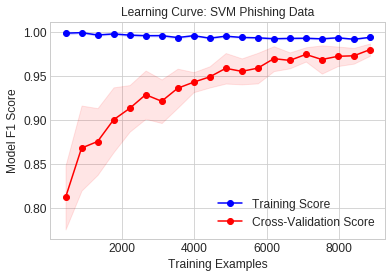

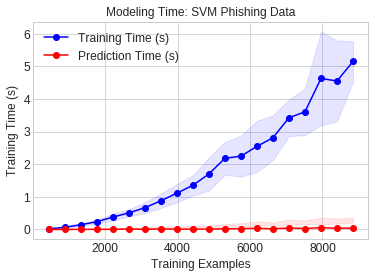

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   4.98333
Model Prediction Time (s): 0.75204

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.97
Precision: 0.97     Recall:    0.98
*****************************************************


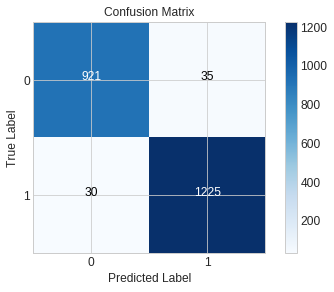

In [8]:
phishX,phishY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Phishing Data)\nHyperparameter : Kernel Function")
C_val, gamma_val = SVMGridSearchCV(X_train, y_train)
estimator_phish = SVC(C=C_val, gamma=gamma_val, kernel='rbf', random_state=100)
learning_curve(estimator_phish, X_train, X_test, y_train, y_test)
train_samp_phish, SVM_train_score_phish, SVM_fit_time_phish, SVM_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="SVM Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

# KNN Classifier

This section will build a classifier using K-nearest neighbors. The hyperparameter will be n_neighbors. One could easily add the distance metric as another hyperparameter, but for simplicity, and for the sake of running the code faster, I won't explore this. I will use the standard euclidean distance for all models. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [9]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

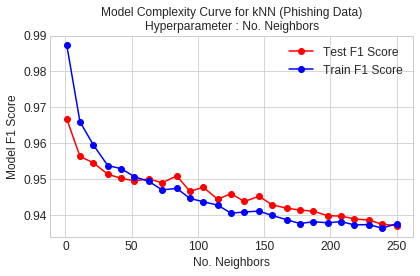

Offsets		Train Err		Test Err
000884		0.048643		0.062217
Offsets		Train Err		Test Err
001149		0.046997		0.069626
Offsets		Train Err		Test Err
001414		0.055163		0.065064
Offsets		Train Err		Test Err
001679		0.040500		0.059559
Offsets		Train Err		Test Err
001944		0.039095		0.060700
Offsets		Train Err		Test Err
002209		0.040742		0.066093
Offsets		Train Err		Test Err
002474		0.040420		0.066033
Offsets		Train Err		Test Err
002739		0.036510		0.064224
Offsets		Train Err		Test Err
003004		0.036285		0.061058
Offsets		Train Err		Test Err
003269		0.037932		0.060606
Offsets		Train Err		Test Err
003534		0.040181		0.058797
Offsets		Train Err		Test Err
003799		0.037641		0.054726
Offsets		Train Err		Test Err
004064		0.035679		0.051560
Offsets		Train Err		Test Err
004329		0.033264		0.049751
Offsets		Train Err		Test Err
004594		0.033522		0.050204
Offsets		Train Err		Test Err
004859		0.034163		0.050656
Offsets		Train Err		Test Err
005124		0.030835		0.050656
Offsets		Train Err		Test Err
005389		0.031175		0

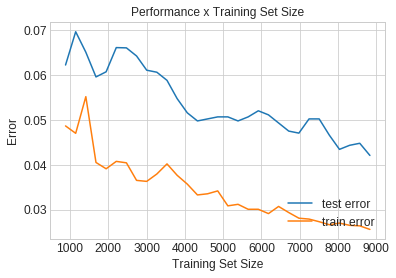

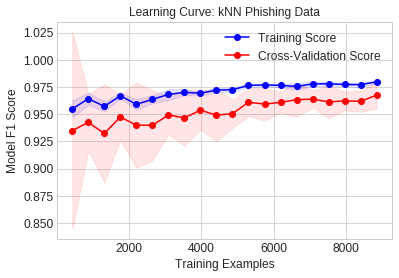

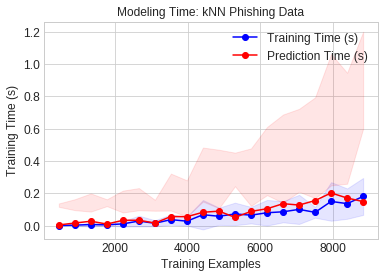

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.07453
Model Prediction Time (s): 0.60972

F1 Score:  0.96
Accuracy:  0.96     AUC:       0.96
Precision: 0.96     Recall:    0.97
*****************************************************


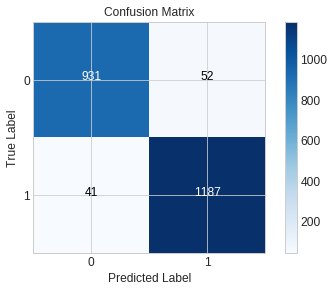

In [10]:
phishX,phishY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
hyperKNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Phishing Data)\nHyperparameter : No. Neighbors")
estimator_phish = kNN(n_neighbors=5, n_jobs=-1)
learning_curve(estimator_phish, X_train, X_test, y_train, y_test)
train_samp_phish, kNN_train_score_phish, kNN_fit_time_phish, kNN_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="kNN Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

# Decision Tree Classifier

This section will build a Decision Tree Classifier using information gain (based on entropy) to determine the best feature split per the ID3 algorithm. The model will be pre-pruned by limiting tree depth using the hyperparameter 'max_depth' and by ensuring that each leaf (a terminal node on the tree) has at least 'min_samples_leaf'. 

In [11]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

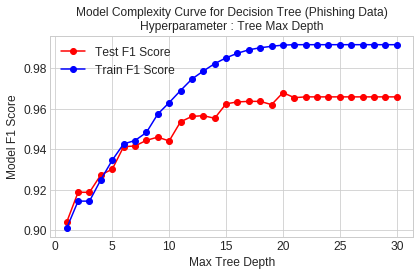

Per Hyperparameter tuning, best parameters are:
{'max_depth': 9, 'min_samples_leaf': 44}
Offsets		Train Err		Test Err
000884		0.102941		0.107466
Offsets		Train Err		Test Err
001149		0.101828		0.108790
Offsets		Train Err		Test Err
001414		0.097595		0.102546
Offsets		Train Err		Test Err
001679		0.091721		0.099464
Offsets		Train Err		Test Err
001944		0.070473		0.078704
Offsets		Train Err		Test Err
002209		0.071978		0.076958
Offsets		Train Err		Test Err
002474		0.072757		0.076888
Offsets		Train Err		Test Err
002739		0.068638		0.094075
Offsets		Train Err		Test Err
003004		0.071904		0.071009
Offsets		Train Err		Test Err
003269		0.072805		0.074627
Offsets		Train Err		Test Err
003534		0.074137		0.073270
Offsets		Train Err		Test Err
003799		0.070808		0.069652
Offsets		Train Err		Test Err
004064		0.070374		0.072818
Offsets		Train Err		Test Err
004329		0.069762		0.072818
Offsets		Train Err		Test Err
004594		0.069874		0.072818
Offsets		Train Err		Test Err
004859		0.070385		0.076888
Offsets		Train 

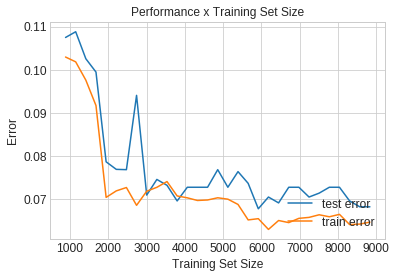

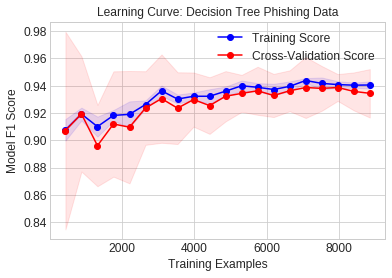

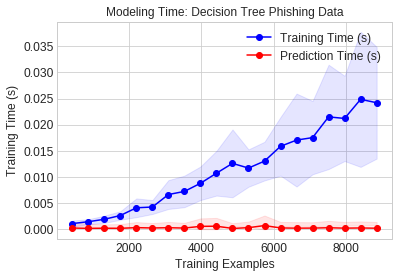

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.03411
Model Prediction Time (s): 0.00036

F1 Score:  0.94
Accuracy:  0.93     AUC:       0.93
Precision: 0.95     Recall:    0.93
*****************************************************


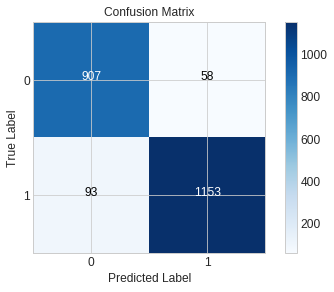

In [12]:
phishX,phishY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Phishing Data)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_phish = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, splitter='random', criterion='entropy')
learning_curve(estimator_phish, X_train, X_test, y_train, y_test)
train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Decision Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

# Boosted Decision Tree Classifier

This section will implement a boosted version of the earlier decision tree. We will still keep the pruning based on max_depth and min_samples_leaf, but the cutoff thresholds will be more aggressive (lower) since the power of boosting is to combine multiple weak learners. We also introduce the hyperparameter of n_estimators and learning rate which will determine the contribution of each tree classifier.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

def hyperBoost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), 
                                             min_samples_leaf=int(min_samples_leaf/2), random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #n_estimators, learning_rate, max_depth, min_samples_leaf
    param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
                  'max_depth': np.arange(1,4),
                  'n_estimators': np.linspace(10,100,3).round().astype('int'),
                  'learning_rate': np.linspace(.001,.1,3)}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

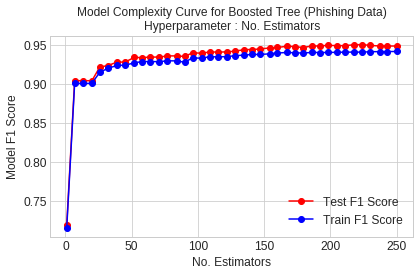

Per Hyperparameter tuning, best parameters are:
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 44}
Offsets		Train Err		Test Err
000884		0.031674		0.057692
Offsets		Train Err		Test Err
001149		0.033943		0.052219
Offsets		Train Err		Test Err
001414		0.037482		0.050212
Offsets		Train Err		Test Err
001679		0.038714		0.054795
Offsets		Train Err		Test Err
001944		0.038580		0.056070
Offsets		Train Err		Test Err
002209		0.037121		0.052965
Offsets		Train Err		Test Err
002474		0.037995		0.055179
Offsets		Train Err		Test Err
002739		0.036145		0.055179
Offsets		Train Err		Test Err
003004		0.037949		0.051108
Offsets		Train Err		Test Err
003269		0.041603		0.052465
Offsets		Train Err		Test Err
003534		0.042445		0.052465
Offsets		Train Err		Test Err
003799		0.043169		0.052917
Offsets		Train Err		Test Err
004064		0.043061		0.051108
Offsets		Train Err		Test Err
004329		0.045507		0.052013
Offsets		Train Err		Test Err
004594		0.046582		0.053370
Offsets		Train Err		Test Err

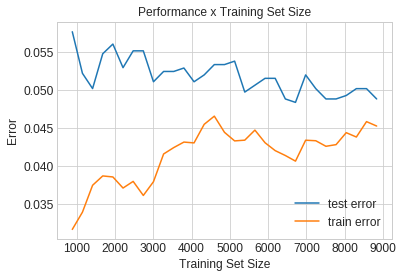

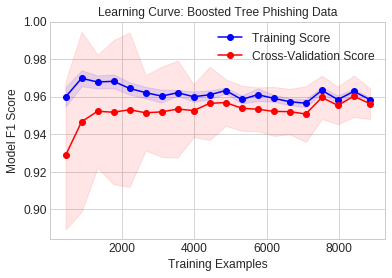

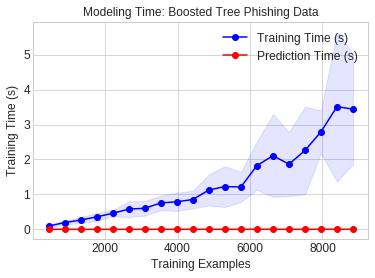

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   1.24206
Model Prediction Time (s): 0.00404

F1 Score:  0.96
Accuracy:  0.95     AUC:       0.95
Precision: 0.96     Recall:    0.95
*****************************************************


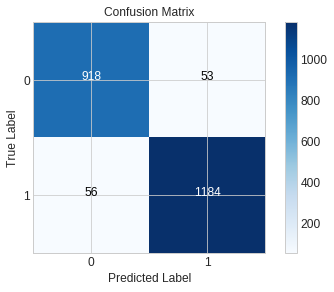

In [14]:
phishX,phishY = import_data()

X_train, X_test, y_train, y_test = train_test_split(np.array(phishX),np.array(phishY), test_size=0.20)
hyperBoost(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Phishing Data)\nHyperparameter : No. Estimators")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf, n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_phish = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                              n_estimators=n_est, learning_rate=learn_rate, random_state=100)
learning_curve(estimator_phish, X_train, X_test, y_train, y_test)
train_samp_phish, BT_train_score_phish, BT_fit_time_phish, BT_pred_time_phish = plot_learning_curve(estimator_phish, X_train, y_train,title="Boosted Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X_train, X_test, y_train, y_test)

# 4. Model Comparison Plots

Finally, let's define and call a function that will plot training times and learning rates for the 5 different algorithms so that we can compare across the classifiers for the same dataset.

In [15]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

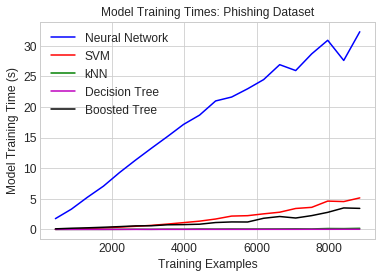

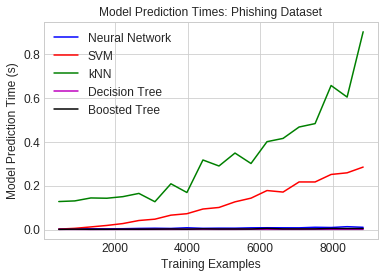

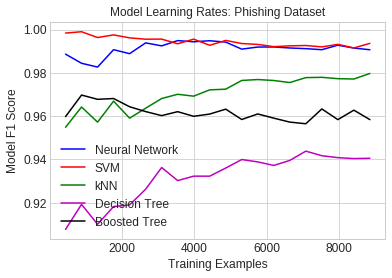

In [16]:
compare_fit_time(train_samp_phish, NN_fit_time_phish, SVM_fit_time_phish, kNN_fit_time_phish, 
                 DT_fit_time_phish, BT_fit_time_phish, 'Phishing Dataset')              
compare_pred_time(train_samp_phish, NN_pred_time_phish, SVM_pred_time_phish, kNN_pred_time_phish, 
                 DT_pred_time_phish, BT_pred_time_phish, 'Phishing Dataset')   
compare_learn_time(train_samp_phish, NN_train_score_phish, SVM_train_score_phish, kNN_train_score_phish, 
                 DT_train_score_phish, BT_train_score_phish, 'Phishing Dataset')  